## general information

This is a Data analysis for the Telecom operator Megaline.
Telecom offers its clients two prepaid plans, Surf and Ultimate. 
We made this analysis to the commercial department for them to know which of the plans brings in more revenue in order to adjust the advertising budget.

We are going to carryijng out a preliminary analysis of the plans based on a relatively small client selection. For this project we have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018.

Our objective here is to analyse clients behavior and determine which prepaid plan brings in more revenue.

**Libraries, Data sets and overview:**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats 
import math
from functools import reduce
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


**data sets:**

In [2]:
call_data = pd.read_csv('/datasets/megaline_calls.csv')
internet_data = pd.read_csv('/datasets/megaline_internet.csv')
sms_data = pd.read_csv('/datasets/megaline_messages.csv')
plan_data = pd.read_csv('/datasets/megaline_plans.csv')
user_data = pd.read_csv('/datasets/megaline_users.csv')

In [3]:
list_of_datasets = [call_data, internet_data, sms_data, plan_data, user_data]
list_of_names = ['call_data','internet_data','sms_data','plan_data','user_data']

In [4]:
for n,d in zip(list_of_names,list_of_datasets):
    print()
    print(n)
    print()
    print(d.info())
    print()
    print(d.describe())
    print()
    print(d.head())


call_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None

             user_id       duration
count  137735.000000  137735.000000
mean     1247.658046       6.745927
std       139.416268       5.839241
min      1000.000000       0.000000
25%      1128.000000       1.290000
50%      1247.000000       5.980000
75%      1365.000000      10.690000
max      1499.000000      37.600000

         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  20

**Overview**

The data presented from the 5 datasets desrcribes the activity of 500 clients, users, in the year of 2018.

The users data:

    user_id — unique user identifier

    first_name — user's name

    last_name — user's last name

    age — user's age (in years)

    reg_date — subscription date ( in the format of - dd, mm, yy)

    churn_date — the date the user stopped using the service (if the value is
    missing, the calling plan was being used when this data was generated)

    city — user's city of residence

    plan — calling plan name

The call data:

    id — unique call identifier
    
    call_date — call date
    
    duration — call duration (in minutes)

    user_id — the identifier of the user making the call

The sms data:

    id — unique text message identifier
    
    message_date — text message date
    
    user_id — the identifier of the user sending the text

The internet data:

    id — unique session identifier

    mb_used — the volume of data spent during the session (in megabytes)

    session_date — web session date

    user_id — user identifier

The plan data:

    plan_name — calling plan name

    usd_monthly_fee — monthly charge in US dollars

    minutes_included — monthly minute allowance

    messages_included — monthly text allowance

    mb_per_month_included — data volume allowance (in megabytes)

    usd_per_minute — price per minute after exceeding the package limits
                    (e.g., if the package includes 100 minutes, the 101st minute will be charged)

    usd_per_message — price per text after exceeding the package limits

    usd_per_gb — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

**Observations:**


-It seem to be that the only missing values are from the user_dataset in the churn_date column. This column represent the date when the user stopped using the service of the company, A missing value indicates that the service was still used when the data was generated 

-Theres some datetime values that appear to be object type, which needs to be reassigned to datetime type.

-Duration column in calls_data needs to be applyed with .ciel() method.

-We have columns with a min value of 0, we need to check how significant their amount is before we begin our statistical analysis. 

-----------------------

## Preparing the data


**A Note**

Megaline has a policy of rounding seconds up to minutes, and megabytes to gigabytes.

For calls, each individual call is rounded up:
whether the call lasted one second, it will be counted as one minute. 
 
For web traffic, individual web sessions are not rounded up.

Instead, the total for the month is rounded up.

If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.



----------------


   **our steps for this data processing will be:**

1) Changing data types: 

-Change all date related columns to a timeframe type and the values to a unified format of (year, month, day).

2) Missing values:

-In this section we will deal with missing values in the churn_date column of the user data by applying the last date of the data to all the missing values in the column.


3) Rounding up the values we need:

-In the calls data we will round up the seconds to minutes for each  individual call.

-In the Internet data we will round up the Megabytes to Gigabytes for each month.

-We will check for values of 0 in the data.

4) Adding new data for each user:

-we add a column of total calls made and minutes used per month.

-we add a column of total sms sent per month.

-we add a column of total data usge in gb per month.

-we add a column of total The monthly revenue from each user.

5) bulding the data frame we will analyze.

6) Counting the monthly revenue of each client

---------------------------------------

**1) Changing data types:**

First we change all date related columns to a timeframe type and the values to a unified format of (year, month, day).

In [5]:
call_data['call_date'] = pd.to_datetime(call_data['call_date'], format ='%Y/%m/%d')
internet_data['session_date'] = pd.to_datetime(internet_data['session_date'], format ='%Y/%m/%d')
sms_data['message_date'] = pd.to_datetime(sms_data['message_date'], format ='%Y/%m/%d')
user_data['reg_date'] = pd.to_datetime(call_data['call_date'], format ='%Y/%m/%d')

In [6]:
print(internet_data['session_date'].max())
print(sms_data['message_date'].max())
print(call_data['call_date'].max())
print(user_data['reg_date'].max())

2018-12-31 00:00:00
2018-12-31 00:00:00
2018-12-31 00:00:00
2018-12-31 00:00:00


**2) Missing values:**

Now we deal with missing values in the churn_date column of the user data by applying the last date of the data to all the missing values in the column

In [7]:
user_data['churn_date'].fillna('2018-12-31',inplace=True)
user_data['churn_date'] = pd.to_datetime(user_data['churn_date'], format ='%Y/%m/%d')
user_data['churn_date'].head()

0   2018-12-31
1   2018-12-31
2   2018-12-31
3   2018-12-31
4   2018-12-31
Name: churn_date, dtype: datetime64[ns]

**3) Rounding up the values we need:**

Here we apply .ceil() method to call_data['duration'] since its one of the company's requirements.

In [8]:
call_data['duration']

0          8.52
1         13.66
2         14.48
3          5.76
4          4.22
          ...  
137730     8.72
137731    10.89
137732     8.12
137733     0.37
137734    13.86
Name: duration, Length: 137735, dtype: float64

In [9]:
call_data['duration'] = np.ceil(call_data['duration']).astype(int)
call_data['duration']

0          9
1         14
2         15
3          6
4          5
          ..
137730     9
137731    11
137732     9
137733     1
137734    14
Name: duration, Length: 137735, dtype: int64

Here we apply .ceil() method to round up the month traffic internet_data['mb_used'] since its one of the company's requirements.

In [10]:
internet_data['gb_used'] = internet_data['mb_used']/ 1024



In [11]:
internet_data['gb_used'].head()

0    0.087754
1    0.000000
2    0.644922
3    0.264639
4    0.859590
Name: gb_used, dtype: float64

In [12]:
internet_data

,id,user_id,session_date,mb_used,gb_used
0,1000_13,1000,2018-12-29,89.86,0.087754
1,1000_204,1000,2018-12-31,0.00,0.000000
2,1000_379,1000,2018-12-28,660.40,0.644922
3,1000_413,1000,2018-12-26,270.99,0.264639
4,1000_442,1000,2018-12-27,880.22,0.859590
...,...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06,0.212949
104821,1499_216,1499,2018-12-30,304.72,0.297578
104822,1499_217,1499,2018-09-22,292.75,0.285889
104823,1499_218,1499,2018-12-07,0.00,0.000000


-Now we will check if the values of 0 in the call_data['duration'] and internet_data['gb_used'] have a significant volume in the datasets.

In [13]:
def distributions(data,parameter):
    print('A histogram of: {}'.format(parameter))
    print('')
    sns.histplot(data=data,x=parameter)
    if data[parameter].median()<data[parameter].mean():
        print('The distribution is skewed to the right')
    else:
        print('The distribution is skewed to the left')
    print('---------------------------------------')
    print('Statistics on: {}'.format(parameter))
    print(data[parameter].describe())
    
    ninety_eight = np.percentile(data[parameter], 98)
    two = np.percentile(data[parameter], 2)
    print('---------------------------------------')
    print('min border:',two)
    print('max border:',ninety_eight)
    print('---------------------------------------')
    print('The outliers are considered to be values below',two, 'and above',ninety_eight)
    print('We have',len(data[(data[parameter]<two)|(data[parameter]>ninety_eight)]),'values that we can consider outliers')

A histogram of: duration

The distribution is skewed to the right
---------------------------------------
Statistics on: duration
count    137735.000000
mean          7.146673
std           5.953919
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64
---------------------------------------
min border: 0.0
max border: 21.0
---------------------------------------
The outliers are considered to be values below 0.0 and above 21.0
We have 2157 values that we can consider outliers


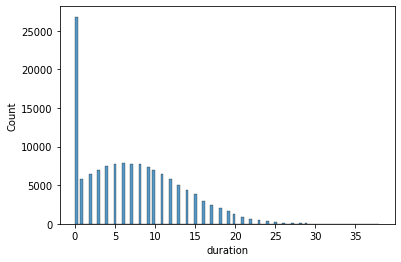

In [14]:
distributions(call_data,'duration')

A histogram of: gb_used

The distribution is skewed to the right
---------------------------------------
Statistics on: gb_used
count    104825.000000
mean          0.358119
std           0.270674
min           0.000000
25%           0.132891
50%           0.335918
75%           0.541611
max           1.653779
Name: gb_used, dtype: float64
---------------------------------------
min border: 0.0
max border: 0.9681707031250004
---------------------------------------
The outliers are considered to be values below 0.0 and above 0.9681707031250004
We have 2097 values that we can consider outliers


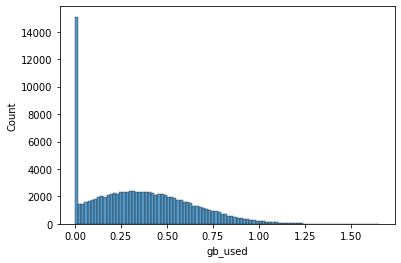

In [15]:
distributions(internet_data,'gb_used')

**Note**

We see that althrough there are many values of 0 in the datasets they dont seem to effect the distribution by any means so we can either leave them or remove them as it wouldnt make any change. 

**4) Adding new data for each user:**

first we being with sms values per client:

In [16]:
sms_per_client= sms_data.pivot_table(index=['user_id','message_date'],values='id',aggfunc='count').reset_index()
sms_per_client.rename(columns={'id':'sms_count'},inplace=True)
sms_per_client.head()

,user_id,message_date,sms_count
0,1000,2018-12-25,1
1,1000,2018-12-26,1
2,1000,2018-12-27,3
3,1000,2018-12-28,1
4,1000,2018-12-29,1


In [17]:
sms_per_client['month'] = pd.to_datetime(sms_per_client['message_date']).dt.month
sms_per_client.head()

,user_id,message_date,sms_count,month
0,1000,2018-12-25,1,12
1,1000,2018-12-26,1,12
2,1000,2018-12-27,3,12
3,1000,2018-12-28,1,12
4,1000,2018-12-29,1,12


In [18]:
sms_per_month = sms_per_client.groupby(['user_id','month'], as_index=False)['sms_count'].count()
sms_per_month.head()

,user_id,month,sms_count
0,1000,12,7
1,1001,8,14
2,1001,9,23
3,1001,10,25
4,1001,11,19


we created a pivot table for sms data in which theres an sms count for each day when the client sent sms and a column on which month it was.

Now we continue with call dutation per client for each month:

In [19]:
call_per_client= call_data.pivot_table(index=['user_id','call_date'],values='id',aggfunc='count').reset_index()
call_per_client.rename(columns={'id':'call_count'},inplace=True)

In [20]:
call_data['month'] = pd.to_datetime(call_data['call_date']).dt.month
call_data.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,15,12
3,1000_309,1000,2018-12-28,6,12
4,1000_380,1000,2018-12-30,5,12


In [21]:
calls_per_month = call_data.groupby(['user_id', 'month'], as_index=False)['duration'].sum()
calls_per_month.head()

,user_id,month,duration
0,1000,12,124
1,1001,8,182
2,1001,9,315
3,1001,10,393
4,1001,11,426


Continuing to internet usage:

In [22]:
internet_data['month'] = pd.to_datetime(internet_data['session_date']).dt.month
internet_data.head()

,id,user_id,session_date,mb_used,gb_used,month
0,1000_13,1000,2018-12-29,89.86,0.087754,12
1,1000_204,1000,2018-12-31,0.00,0.000000,12
2,1000_379,1000,2018-12-28,660.40,0.644922,12
3,1000_413,1000,2018-12-26,270.99,0.264639,12
4,1000_442,1000,2018-12-27,880.22,0.859590,12


In [23]:
gb_per_month = internet_data.groupby(['user_id','month'], as_index=False)['gb_used'].sum()
gb_per_month['gb_used'] = gb_per_month['gb_used'].apply(np.ceil)
gb_per_month.head()

,user_id,month,gb_used
0,1000,12,2.0
1,1001,8,7.0
2,1001,9,14.0
3,1001,10,22.0
4,1001,11,19.0


After adjusting the data to our needs.
We can merge it together into a dataframe that we can analyse

**5) bulding the data frame we will analyze.**

In [24]:
data_frames = [calls_per_month, sms_per_month, gb_per_month]
data_month = reduce(lambda  left,right: pd.merge(left,right,on=['user_id','month'],
                                            how='outer'), data_frames).fillna(0)

In [25]:
data_month

,user_id,month,duration,sms_count,gb_used
0,1000,12,124.0,7.0,2.0
1,1001,8,182.0,14.0,7.0
2,1001,9,315.0,23.0,14.0
3,1001,10,393.0,25.0,22.0
4,1001,11,426.0,19.0,19.0
...,...,...,...,...,...
2288,1349,12,0.0,28.0,13.0
2289,1361,5,0.0,2.0,2.0
2290,1482,10,0.0,1.0,0.0
2291,1108,12,0.0,0.0,1.0


In [26]:
data= pd.merge(left = user_data ,right = data_month, how='outer',on=['user_id']).fillna(0)


**This is the dataframe we will conduct our analysis from.**

In [27]:
data.head(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,duration,sms_count,gb_used
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-27,ultimate,2018-12-31,12.0,124.0,7.0,2.0
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-12-27,surf,2018-12-31,8.0,182.0,14.0,7.0
2,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-12-27,surf,2018-12-31,9.0,315.0,23.0,14.0
3,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-12-27,surf,2018-12-31,10.0,393.0,25.0,22.0
4,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-12-27,surf,2018-12-31,11.0,426.0,19.0,19.0
5,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-12-27,surf,2018-12-31,12.0,412.0,25.0,19.0
6,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-12-27,surf,2018-12-31,10.0,59.0,8.0,7.0
7,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-12-27,surf,2018-12-31,11.0,386.0,21.0,19.0
8,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-12-27,surf,2018-12-31,12.0,384.0,22.0,15.0
9,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-12-28,surf,2018-12-31,12.0,1104.0,14.0,27.0


This dataframe has all the monthly information on each client in our data.


**6) Counting the monthly revenue of each client**

In [28]:
def revenue(row):
    #by using row accessor we will take each row of each client separately
    # so we're creating variables of plans/duration/gbytes/sms inside the function
    # and we can operate them for each user
    sms=row['sms_count']
    duration=row['duration']
    gb=row['gb_used']
    plan=row['plan']
    
    plan_cost = 0  
    internet_cost = 0
    calls_cost = 0
    sms_cost = 0
    
    if plan == 'surf':
        plan_cost=20
        if sms>50:
            sms_cost=(sms-50)*0.03
        if duration>500:
            calls_cost=(duration-500)*0.03
        if gb>15:
            internet_cost=(gb-15)*10
            
    elif plan == 'ultimate':
        plan_cost=70
        if sms>1000:
            sms_cost=(sms-100)*0.01
        if duration>3000:
            calls_cost>(duration - 3000) * 0.01
        if gb > 30:
            internet_cost = (gb - 30) * 7.
#now calculate the total cost by simply summing it all up
    total_cost=plan_cost+internet_cost+calls_cost+sms_cost
    return total_cost

In [29]:
data[data['user_id']==1138]

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,duration,sms_count,gb_used
651,1138,Arlie,Higgins,66,"Riverside-San Bernardino-Ontario, CA MSA",2018-10-05,surf,2018-12-31,2.0,307.0,6.0,16.0
652,1138,Arlie,Higgins,66,"Riverside-San Bernardino-Ontario, CA MSA",2018-10-05,surf,2018-12-31,3.0,363.0,11.0,18.0
653,1138,Arlie,Higgins,66,"Riverside-San Bernardino-Ontario, CA MSA",2018-10-05,surf,2018-12-31,4.0,321.0,9.0,20.0
654,1138,Arlie,Higgins,66,"Riverside-San Bernardino-Ontario, CA MSA",2018-10-05,surf,2018-12-31,5.0,381.0,15.0,23.0
655,1138,Arlie,Higgins,66,"Riverside-San Bernardino-Ontario, CA MSA",2018-10-05,surf,2018-12-31,6.0,530.0,13.0,19.0
656,1138,Arlie,Higgins,66,"Riverside-San Bernardino-Ontario, CA MSA",2018-10-05,surf,2018-12-31,7.0,399.0,11.0,24.0
657,1138,Arlie,Higgins,66,"Riverside-San Bernardino-Ontario, CA MSA",2018-10-05,surf,2018-12-31,8.0,549.0,6.0,19.0
658,1138,Arlie,Higgins,66,"Riverside-San Bernardino-Ontario, CA MSA",2018-10-05,surf,2018-12-31,9.0,374.0,14.0,21.0
659,1138,Arlie,Higgins,66,"Riverside-San Bernardino-Ontario, CA MSA",2018-10-05,surf,2018-12-31,10.0,469.0,5.0,24.0
660,1138,Arlie,Higgins,66,"Riverside-San Bernardino-Ontario, CA MSA",2018-10-05,surf,2018-12-31,11.0,375.0,6.0,17.0


In [30]:
data['revenue']=data.apply(revenue,axis=1)
data.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,duration,sms_count,gb_used,revenue
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-27,ultimate,2018-12-31,12.0,124.0,7.0,2.0,70.0
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-12-27,surf,2018-12-31,8.0,182.0,14.0,7.0,20.0
2,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-12-27,surf,2018-12-31,9.0,315.0,23.0,14.0,20.0
3,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-12-27,surf,2018-12-31,10.0,393.0,25.0,22.0,90.0
4,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-12-27,surf,2018-12-31,11.0,426.0,19.0,19.0,60.0


After adding the total revenue per month for each client we ready  to analyze which plan brings more revenue

## Analyzing the Data

In this pant we describe the customers behavior. We do it by Calculating the mean, variance, and standard
deviation. 
First we will plot histograms for comparing the plans by the different columns, boxplots and then describe the distributions.

In [31]:
def distribution(parameter):
    print('The histogram and boxplot of: {}'.format(parameter))
    print('')
    fig, axes = plt.subplots(1,2,figsize=(16, 5))
    sns.histplot(data=data,bins=100,x=parameter,hue='plan',ax=axes[0])
    sns.boxplot(data=data,x=parameter,y='plan',showfliers = False, orient="h", palette="Set2",ax=axes[1])
    if data[parameter].median()>data[parameter].median():
        print('The distribution is skewed to the right')
    else:
        print('The distribution is skewed to the left')
    print('')
    print('Statistics on: {}'.format(parameter))
    print('Standard deviation is {}'.format(data[parameter].std()))
    print('Variance is {}'.format(data[parameter].var()))
    print(data[parameter].describe())

The histogram and boxplot of: duration

The distribution is skewed to the left

Statistics on: duration
Standard deviation is 237.4902941073229
Variance is 56401.63979518273
count    2303.000000
mean      427.419453
std       237.490294
min         0.000000
25%       262.500000
50%       424.000000
75%       571.500000
max      1510.000000
Name: duration, dtype: float64


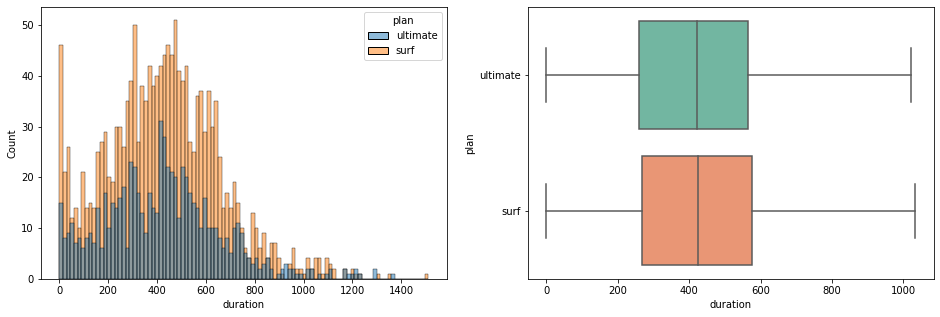

In [32]:
distribution('duration')

The histogram and boxplot of: sms_count

The distribution is skewed to the left

Statistics on: sms_count
Standard deviation is 10.791723726836153
Variance is 116.4613009963584
count    2303.000000
mean       14.434650
std        10.791724
min         0.000000
25%         2.000000
50%        16.000000
75%        24.000000
max        31.000000
Name: sms_count, dtype: float64


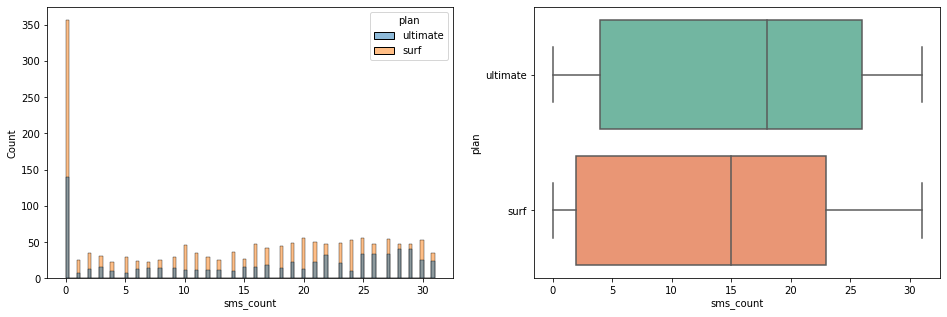

In [33]:
distribution('sms_count')

The histogram and boxplot of: gb_used

The distribution is skewed to the left

Statistics on: gb_used
Standard deviation is 7.85794551087151
Variance is 61.74730765182573
count    2303.000000
mean       16.797221
std         7.857946
min         0.000000
25%        12.000000
50%        17.000000
75%        21.000000
max        70.000000
Name: gb_used, dtype: float64


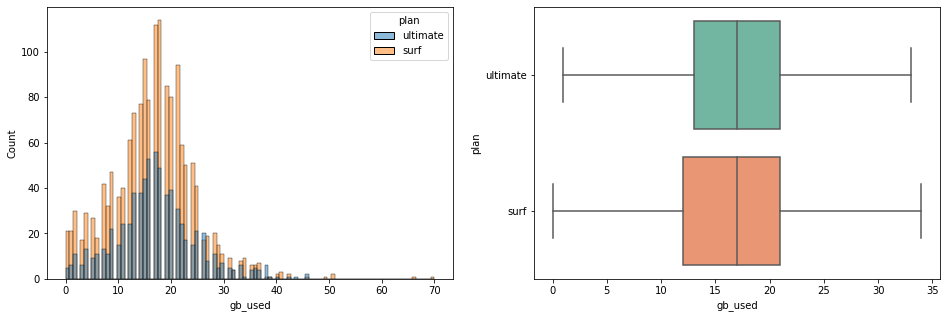

In [34]:
distribution('gb_used')

Based on the histograms:

clients with the ultimate plan use less sms, less surfing data and spoke less minutes than the surf clients.

Bases on the boxplots:

The call durations of the clients in both plans were the very similiar, and slighlty higher for surf clients

Morever, surf plan clients seem to use more gigabyes than ultimate plan clients that have a more centered usage.
Regarding SMS values, the boxplon shows that ultimate clients send more sms than surf clients as the distribution of the ultimate clients is higher.


## Testing the hypotheses

in this part we intend to check:

-How the average revenue from users of Ultimate and Surf calling plans differs.

-How the average revenue from users in NY-NJ area is different from that of the users
from other regions.

-For the t-tests alpha will equal 0.05

**procedure:**
      
      - For the first hypothesis:
    
        H0: Average of revenue of ultimate clients equal to average of revenue of surf clients.
        
        H1: Average of revenue of ultimate clients not equal to average of revenue of surf clients.
      

1) We will seperate the revenue values from the dataframes to test out our hypothesis of them.

2) We will compare the revenue of this 2 different plans by using t-test.

3) Presenting findings.

       - For the second hypothesis:
       
       H0: Average of revenue of clients from the NY-NJ region is equal to average of revenue of clients of other regions.
        
       H1: Average of revenue of clients from the NY-NJ region is not equal to average of revenue of clients of 
       other regions.
        

1) We will devide the data by regions and then extract the revenue of the regions we are interested in.

2) We will compare the revenue of the regions we specify and the rest of the data revenue by using t-test.

3) Presenting findings.


-------------------------

In [35]:
def t_test(sample1,sample2,alpha=0.05):
    p_value=stats.ttest_ind(sample1, sample2,nan_policy='omit').pvalue.astype(int)
    if p_value<alpha:
        print('Reject H0: average of sample 1 is not equal to average of sample 2')
    else:
        print( "Fail to Reject H0: We don't have enough evidence to say that averages of sample 1 \
  and sample 2 are not the same") 

In [36]:
surf = data.query('plan == "surf"')
surf.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,duration,sms_count,gb_used,revenue
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-12-27,surf,2018-12-31,8.0,182.0,14.0,7.0,20.0
2,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-12-27,surf,2018-12-31,9.0,315.0,23.0,14.0,20.0
3,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-12-27,surf,2018-12-31,10.0,393.0,25.0,22.0,90.0
4,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-12-27,surf,2018-12-31,11.0,426.0,19.0,19.0,60.0
5,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-12-27,surf,2018-12-31,12.0,412.0,25.0,19.0,60.0


In [37]:
ultimate = data.query('plan == "ultimate"')
ultimate.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,duration,sms_count,gb_used,revenue
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-27,ultimate,2018-12-31,12.0,124.0,7.0,2.0,70.0
19,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-12-27,ultimate,2018-12-18,11.0,10.0,3.0,3.0,70.0
20,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-12-27,ultimate,2018-12-18,12.0,59.0,31.0,32.0,84.0
26,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-12-28,ultimate,2018-12-31,10.0,476.0,16.0,17.0,70.0
27,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-12-28,ultimate,2018-12-31,11.0,446.0,21.0,24.0,70.0


# First hypothesis

-The average revenue from users of Ultimate and Surf calling plans differs.

1) we will seperate the revenue values from the dataframes to test out our hypothesis of them.

In [38]:
surf_revenue = surf['revenue']
ultimate_revenue = ultimate['revenue']

In [39]:
surf_revenue.head()

1    20.0
2    20.0
3    90.0
4    60.0
5    60.0
Name: revenue, dtype: float64

In [40]:
ultimate_revenue.head()

0     70.0
19    70.0
20    84.0
26    70.0
27    70.0
Name: revenue, dtype: float64

2) we will compare the revenue of this 2 different plans by using t-test.

In [41]:
t_test(surf_revenue,ultimate_revenue,alpha=0.05)

Reject H0: average of sample 1 is not equal to average of sample 2


In [42]:
print(surf_revenue.mean())
print(ultimate_revenue.mean())

60.34214692843572
72.3011049723757


3) presenting findings:

after running our data sample through a t-test with a statistical significance level of 0.05 our hypothesis on the Equality of the Means of Paired Samples was rejected and the average of surf_revenue is not equal to average of ultimate_revenue.

It seems that the mean of ultimate_revenue lower than the surf revenue.

# Second hypothesis

-The average revenue from users in NY-NJ area is different from that of the users
from other regions.

1) we will devide the data by regions and then extract the revenue of the regions we are interested in.

In [43]:
ny_nj = data[data['city'].str.contains("NY")]
regions = data[~ data['city'].str.contains("NY")]
ny_nj.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,duration,sms_count,gb_used,revenue
56,1014,Edmundo,Simon,61,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-12-26,surf,2018-12-31,11.0,163.0,5.0,2.0,20.00
57,1014,Edmundo,Simon,61,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-12-26,surf,2018-12-31,12.0,1114.0,27.0,8.0,38.42
75,1022,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-11-17,surf,2018-09-07,5.0,302.0,0.0,5.0,20.00
76,1022,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-11-17,surf,2018-09-07,6.0,490.0,0.0,23.0,100.00
77,1022,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-11-17,surf,2018-09-07,7.0,475.0,0.0,10.0,20.00


In [44]:
regions.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,duration,sms_count,gb_used,revenue
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-27,ultimate,2018-12-31,12.0,124.0,7.0,2.0,70.0
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-12-27,surf,2018-12-31,8.0,182.0,14.0,7.0,20.0
2,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-12-27,surf,2018-12-31,9.0,315.0,23.0,14.0,20.0
3,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-12-27,surf,2018-12-31,10.0,393.0,25.0,22.0,90.0
4,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-12-27,surf,2018-12-31,11.0,426.0,19.0,19.0,60.0


In [45]:
ny_nj_revenue = ny_nj['revenue']
regions_revenue = regions['revenue']
ny_nj_revenue.head()

56     20.00
57     38.42
75     20.00
76    100.00
77     20.00
Name: revenue, dtype: float64

In [46]:
regions_revenue.head()

0    70.0
1    20.0
2    20.0
3    90.0
4    60.0
Name: revenue, dtype: float64

2) we will compare the revenue of the regions we specify and the rest of the data revenue by using t-test.

In [47]:
t_test(ny_nj_revenue,regions_revenue,alpha=0.05)

Reject H0: average of sample 1 is not equal to average of sample 2


In [48]:
print(ny_nj_revenue.mean())
print(regions_revenue.mean())

60.803366093366094
64.80974683544304


3) presenting findings.

after running our data sample through a t-test with a statistical significance level of 0.05 our hypothesis on the Equality of the Means of Paired Samples was rejected and the average of ny_nj_revenue is not equal to average of regions_revenue.

It seems that the mean of all other regions is slightly higher than the New York-Newark-Jersey revenue. Perhaps there are more ultimate clients outside of New York-Newark-Jersey area.

## Overall conclusions

**conclusion of each part:**

1. Preparing the Data

At this part we startedpreparinf the data at the following: 

We changed all date related columns to a timeframe type and the values to a unified format of (year, month, day).

We dealt with missing values in the churn_date column of the user data by applying the last date of the data to all the missing values in the column.

We rounding up the values 

-In the calls data we rounded up the seconds to minutes for each individual call.

-In the Internet data we rounded up the Megabytes to Gigabytes for each month.

We Added new data for each user

-A column of total calls made and minutes used per month.

-A column of total sms sent per month.

-A column of total data usge in gb per month.

-A column of total The monthly revenue from each user.

We built the data frame we later analysed.

And we Counted the monthly revenue of each client

2. Analysis of the data

For this part we used a funtion to tompare the histograms of the 2 plans-Surf and Histogram.
we came to the conclutions that:

-clients of the ultimate plan used less sms compared to clients of the surf plan.

-clients of the ultimate plan used less surfing data and had shjorted duration calls than the surf clients.

Also, we used compared the 2 plans with boxplots and came to the conclutions that:

-The call durations of the clients in both plans were the very similiar, and slighlty higher for surf clients

Morever, surf plan clients seem to use more gigabyes than ultimate plan clients that had more of a centered usage.

-Interesting finding was regarding SMS values of the plans. The boxplots showed that ultimate clients send more sms than surf clients but the ultimate clients distribution is also higher.

3. Hypothesis testing

-The average revenue from users of Ultimate and Surf calling plans differs.

after running our data sample through a t-test with a statistical significance level of 0.05 our hypothesis on the Equality of the Means of Paired Samples was rejected and the average of surf_revenue is not equal to average of ultimate_revenue.
It seems that the mean of ultimate_revenue much higher than the surf revenue.

-The average revenue from users in NY-NJ area is different from that of the users
from other regions.

after running our data sample through a t-test with a statistical significance level of 0.05 our hypothesis on the Equality of the Means of Paired Samples was rejected and the average of ny_nj_revenue is not equal to average of regions_revenue.
It seems that the mean of all other regions is slightly higher than the New York-Newark-Jersey revenue. Perhaps there are more ultimate clients outside of New York-Newark-Jersey area.
